#### Scanning the whole stack and generate projection. operated on the system of bigdata

In [9]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

#### Import the data 

In [10]:
# dataPath = 'F:\LM\digitalConfocal\data\interim\zebra_fish'
dataPath = '/bigdata/casus/MLID/zebrafish/all_toxo'

In [12]:
# define the read in function for TIF

def readTIF(data_path):
    images = []
    for img in glob.glob(os.path.join(data_path, "*.tif")):
        
        im = io.imread(os.path.join(data_path, img))  
        imarray = np.array(im)
        images.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(images)

In [ ]:
# read in the file and obtain the gray channel

rawData = readTIF(dataPath)  # multiple stacks, each contains two channels, each channel 20 imgs
rawGray = rawData[:,:,1,...]  # gray channel with each 20 images as one stack
# rawStack = rawGray[0,...]  # one of the stack as example
# tempStack = np.expand_dims(rawStack, axis=0)  # keep the data format similar


#### max projection in every slice in the stack

In [26]:
# create the folder to save the stacks

import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
#     else:
#         print('path existed')

In [27]:
# multiple scans
def slidingStackSingle(image, stepArray, windowSize):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        stdMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                tempStdPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                # print(tempStdPatch)
                stdMap[y:y + windowSize[1], x:x + windowSize[0]] = tempStdPatch + stdMap[y:y + windowSize[1], x:x + windowSize[0]] 
                # print(tempStd)
                
        focalStack.append(stdMap)
        
    # calculate the stack and conduct max projection
    fMax = np.max(np.asarray(focalStack), axis=0)
    np.save('./fMax/fMaxStack.npy', fMax)

In [28]:
# multiple scans for one image.
# input: stack num, slice num, image, step, windowsize

def slidingStack(stackNum, sliceNum, image, stepArray, windowSize, savedPath):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        stdMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                tempStdPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                # print(tempStdPatch)
                stdMap[y:y + windowSize[1], x:x + windowSize[0]] = tempStdPatch + stdMap[y:y + windowSize[1], x:x + windowSize[0]] 
                # print(tempStd)
                
        focalStack.append(stdMap)
        
    # calculate the stack and conduct max projection
    fMax = np.max(np.asarray(focalStack), axis=0)
    
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)

In [39]:
#  visualize the scanning process of one image

def visualizeStack(stackNum, sliceNum, image, stepArray, windowSize, savedPath):
    
    # slide window scanning for one test
    for (x, y, window) in slidingStack(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        # draw the window during the process
        clone = image.copy() 
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)  # third param indicates the colour
        cv2.imshow("Window", clone)
        cv2.waitKey(1)
           # time.sleep(0.025)
        time.sleep(0.00025)
    cv2.destroyAllWindows() 

#### generate scan on one stack

In [40]:
# define the parameters

# step size
# stepArray = [22, 24]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]
# window size
# (winW, winH) = (256, 256)
(winW, winH) = (128, 128)
# saved path
savedPath = 'F:/LM/digitalConfocal/notebooks/fMax'
# target stack
targetStack = tempStack
# targetStack = tempStack[:,:2,:,:]

In [41]:
# scan the images in step size

for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStack(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 

#### load the max projection for next step

In [42]:
# define the read in function for max projection

def readTIF(data_path):
    fStack = []
    for img in glob.glob(os.path.join(data_path, "*.npy")):
        im = np.load(os.path.join(data_path, img))  
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

In [43]:
# read into the calculating results
stackNum = 0
fStack1 = readTIF(savedPath+'/'+str(stackNum)+'/')

In [44]:
# napari for the 3D visualization 
import napari

viewer = napari.view_image(fStack1)  # visualize the volume in layers
napari.run()  # start the "event loop" and show the viewer

#### dock the images together and check the results

In [45]:
dockIMG = []

for i in range(fStack1.shape[0]):
    tFmax = fStack1[i,...]
    tStack = np.squeeze(targetStack[:,i,:,:])
    scanScale = np.interp(tFmax, (tFmax.min(), tFmax.max()), (0, 255))  # since the original images is uint8
    sumImg = scanScale + 1 * tStack
    sumImg = np.interp(sumImg, (sumImg.min(), sumImg.max()), (0, 1))  # rescale into [0, 1]
    dockIMG.append(sumImg)
    
dockIMG = np.asarray(dockIMG)

In [46]:
viewer = napari.view_image(dockIMG)  # visualize the volume in layers
napari.run() 

#### sanity check for slices in stack

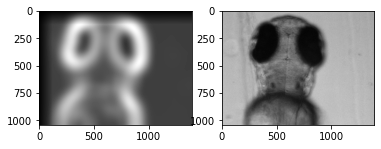

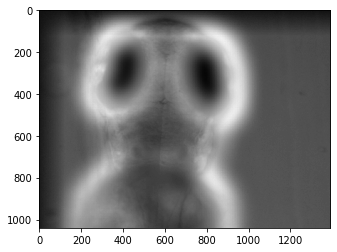

In [47]:
# compare the generated images with the original slice
NUM = 0
tFmax = fStack1[NUM,...]; tStack = np.squeeze(targetStack[:,NUM,:,:])
plt.subplot(1,2,1)
plt.imshow(tFmax, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(tStack, cmap='gray')
plt.show()

# dock the images

scanScale = np.interp(tFmax, (tFmax.min(), tFmax.max()), (0, 255))
sumImg = scanScale + 2 * tStack
sumImg = np.interp(sumImg, (sumImg.min(), sumImg.max()), (0, 255))
plt.figure()
plt.imshow(sumImg, cmap='gray')

#### binary the feature map

In [48]:
for i in range(fStack1.shape[0]):
    tSlice = fStack1[i,...]
    print(np.max(tSlice), np.min(tSlice))

2722.996158376707 2.5580143367104227
3748.1890299045554 2.8409337545321325
5848.687742046888 3.2965550561210275
5876.278559234981 3.3229690689506133
5925.149677420879 3.3016282275906277
5967.305921541709 3.3163504421719137
6011.688079645345 3.313136547371999
6062.773426395746 3.376587917487292
6100.057505714209 3.4747741021171845
6169.431546899018 3.7451675784663707
6208.273277687608 3.9024755662796813
6234.003740300303 4.063650133019217
4534.057129628859 3.0366018128752894
5007.730088932657 3.1585043508137898
5308.317019917803 3.241484469290349
5485.202855691909 3.2309621177011834
5573.917406909079 3.2491976952380828
5675.048043970465 3.2814384264431267
5726.296807084611 3.288090279023692
5789.873918938968 3.255050347563417


In [54]:
# rescale the images
# set the threshold as half of the value
scanScale = np.interp(fStack1, (fStack1.min(), fStack1.max()), (0, 1))
THRESHOLD = 0.25
biFmax = (scanScale > THRESHOLD).astype('float')

In [55]:
# dock check the effects
biStack = np.squeeze(targetStack)
sumImg = biFmax + 2 * np.interp(biStack, (biStack.min(), biStack.max()), (0, 1))
sumImg = np.interp(sumImg, (sumImg.min(), sumImg.max()), (0, 1))
viewer = napari.view_image(sumImg)  # visualize the volume in layers
napari.run() 

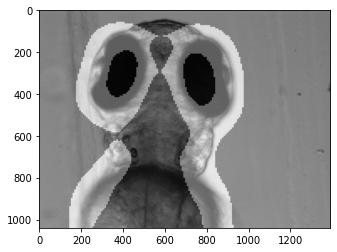

In [51]:
plt.figure()
plt.imshow(sumImg[10,...], cmap='gray')

#### write out the feature map as tif

In [59]:
# write out the calculate mask

import numpy as np
import tifffile

with tifffile.TiffWriter('fMax.tif') as tif:
  for i in range(fStack1.shape[0]):
    filename = f"image_{i}"
    tif.save(fStack1[i,...], photometric='minisblack', description=filename, metadata=None)

In [60]:
test = io.imread('./fMax.tif')  
viewer = napari.view_image(test)  # visualize the volume in layers
napari.run() 